<a href="https://colab.research.google.com/github/gopikasb/AIESI/blob/master/layout_parser_extract_tables_from_imagedoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install -U layoutparser

In [18]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2'


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-c_05qxj3/detectron2_0ed9b59aff51408894eebdcb7a8f3f83
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-c_05qxj3/detectron2_0ed9b59aff51408894eebdcb7a8f3f83
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Created wheel for detectron2: filename=detectron2-0.5-cp37-cp37m-linux_x86_64.whl size=5351628 sha256=ba2c6667a1506eaa2c459db235382bad0128679b5c3bb4296c3d712b87a35f6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-94cg_of0/wheels/75/69/b4/caca235626d537eca323727494360664a9e97b82b570e78fcd
Successfully built detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu101
    Uninstalling detectron2-0.6+cu101:
      Successfully uninstalled detectron2-0.6+cu101


In [1]:
!pip install layoutparser[ocr]

     |████████████████████████████████| 435 kB 12.5 MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14070 sha256=28d7f76ceeeec90717b336dfb65e4c2382914a61a67e146ce02d3d485cd506a1
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [1]:
!git clone https://github.com/Layout-Parser/layout-parser.git

Cloning into 'layout-parser'...
remote: Enumerating objects: 1265, done.
remote: Counting objects: 100% (771/771), done.
remote: Compressing objects: 100% (436/436), done.
remote: Total 1265 (delta 442), reused 536 (delta 272), pack-reused 494
Receiving objects: 100% (1265/1265), 63.95 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (671/671), done.


In [2]:
%cd layout-parser/

/content/layout-parser


In [3]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/example-table.jpeg")
image = image[..., ::-1]

config.yaml?dl=1: 8.19kB [00:01, 5.09kB/s]
model_final.pth?dl=1: 856MB [00:54, 15.6MB/s]
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshg

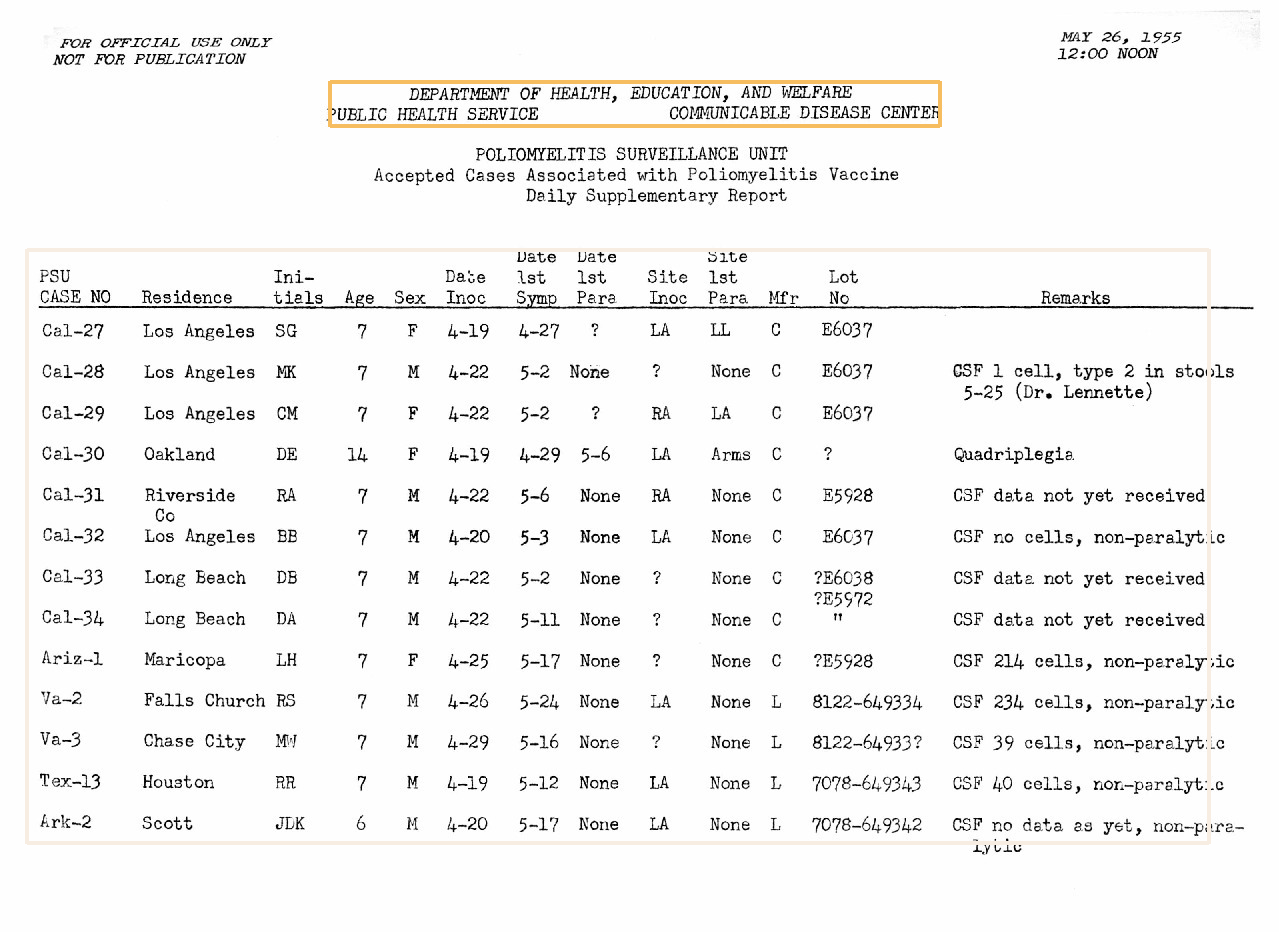

In [4]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [5]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=27.7454833984375, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text=None, id=None, type=Table, parent=None, next=None, score=0.9762899279594421)], page_data={})

In [6]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [7]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [8]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

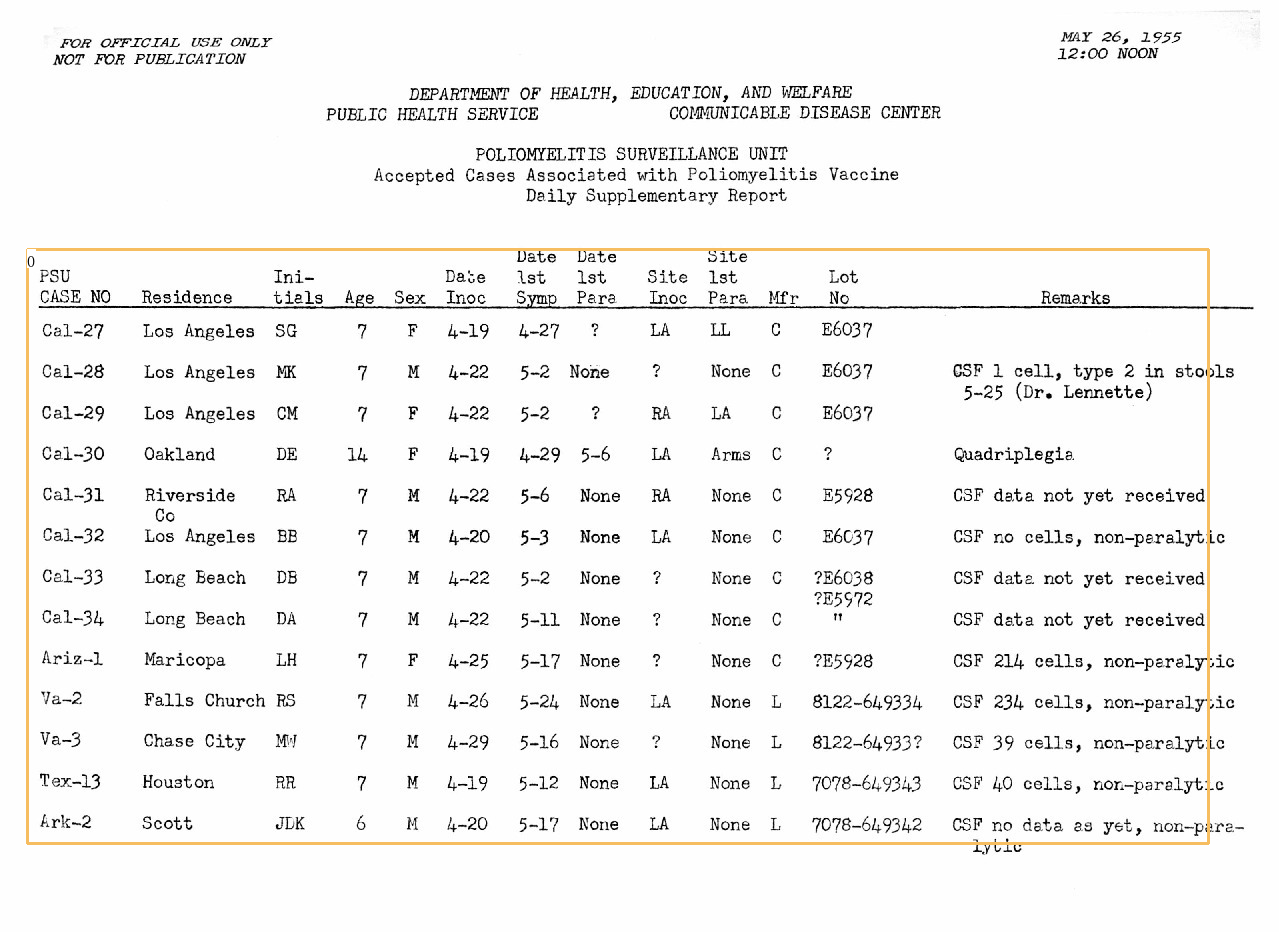

In [9]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [10]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [11]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [12]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [13]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti
Tex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—parelyti
Ark~2 Scott DK 

In [14]:
text_blocks.get_texts()

[' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—par

In [15]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=27.7454833984375, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text= 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 

In [16]:

!pip install spacy

In [17]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

     |████████████████████████████████| 51 kB 96 kB/s 
     |████████████████████████████████| 451 kB 28.3 MB/s 
     |████████████████████████████████| 6.0 MB 63.6 MB/s 
     |████████████████████████████████| 3.4 MB 56.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 10.1 MB 36.1 MB/s 
     |████████████████████████████████| 181 kB 47.1 MB/s 
     |████████████████████████████████| 628 kB 54.3 MB/s 
     |████████████████████████████████| 42 kB 947 kB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.

In [18]:
!pip install click==7.1.1

     |████████████████████████████████| 82 kB 751 kB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 21.4b2 requires click>=7.1.2, but you have click 7.1.1 which is incompatible.


In [19]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [20]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [21]:
".".join(sentence)

' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—pare

In [22]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 CARDINAL
2 CARDINAL
2 CARDINAL
785928 CARDINAL
214 CARDINAL


In [ ]:
#

#Detecting Tables

In [ ]:
#saving table to CSV
dataframe.to_csv('file1.csv')
